# Developing Allometric Equations

In [1]:
import model_utils as mu
import data_utils as du
import pandas as pd
import numpy as np
import pickle
import os

In [2]:
df = pd.read_csv('csv_files/final_dataset_filtered.csv') 

In [3]:
df.columns

Index(['img_path', 'xmin', 'ymin', 'xmax', 'ymax', 'score', 'img_name',
       'tile_index', 'tile_xmin', 'tile_ymin', 'tile_xmax', 'tile_ymax', 'x',
       'y', 'Xmin', 'Ymin', 'Xmax', 'Ymax', 'X_d', 'Y_d', 'lon_d', 'lat_d',
       'is_musacea_d', 'is_banana', 'ground_index', 'name', 'lat_g', 'lon_g',
       'diameter', 'height', 'year', 'plot_id', 'tree_id', 'is_musacea_g',
       'site', 'X_g', 'Y_g', 'updated diameter', 'group', 'updated height',
       'AGB', 'carbon', 'id', 'unique_id'],
      dtype='object')

In [4]:
test_df = pd.read_csv('csv_files/test_data_SEDD.csv')

In [5]:
df = mu.split_data_from_test_df(test_df, df)

In [6]:
df = mu.add_bbox_columns(df)

In [7]:
#extract relevant columns 
df_relevant = df[['name', 'diameter', 'AGB']]

In [8]:
#combining everything under 80 to 'other'
df_relevant['name'] = df_relevant['name'].apply(lambda x: x if x in ['Musacea','Guaba','Cacao','Mango'] else 'Otra variedad')

/var/folders/ym/hz9zm7z56_z32pf0g7q1mxdw0000gp/T/ipykernel_21407/4174086897.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_relevant['name'] = df_relevant['name'].apply(lambda x: x if x in ['Musacea','Guaba','Cacao','Mango'] else 'Otra variedad')


## Exploration of the Data

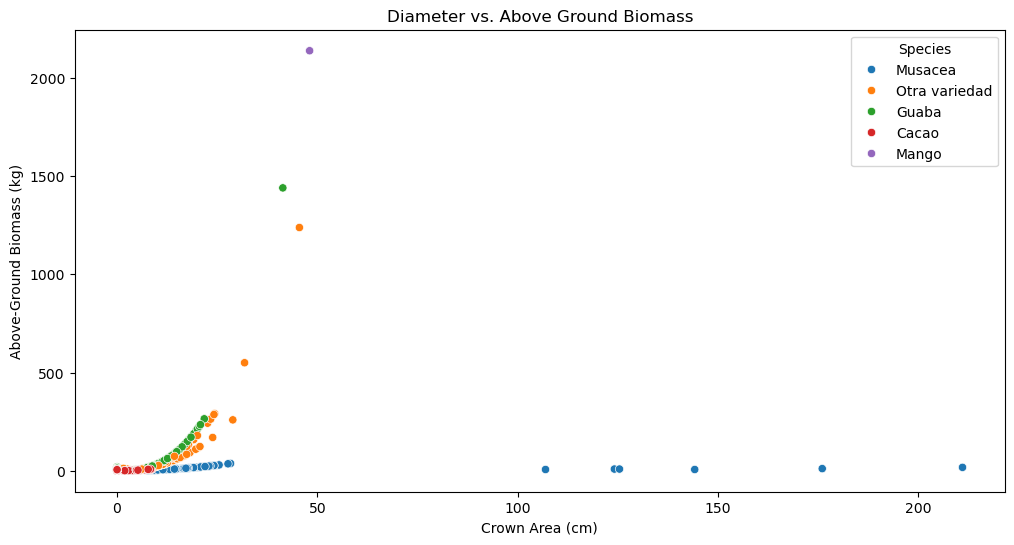

In [9]:
mu.visualize_allometric_relationship(df_relevant, 'Diameter vs. Above Ground Biomass')

## Removing Outliers

In [10]:
df_cleaned = df_relevant.groupby('name').apply(lambda x: mu.remove_outliers(x, 'AGB')).reset_index(drop=True)
df_cleaned = df_cleaned.groupby('name').apply(lambda x: mu.remove_outliers(x, 'diameter')).reset_index(drop=True)


/var/folders/ym/hz9zm7z56_z32pf0g7q1mxdw0000gp/T/ipykernel_21407/46374127.py:1: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_cleaned = df_relevant.groupby('name').apply(lambda x: mu.remove_outliers(x, 'AGB')).reset_index(drop=True)
/var/folders/ym/hz9zm7z56_z32pf0g7q1mxdw0000gp/T/ipykernel_21407/46374127.py:2: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_cleaned = df_cleaned.groupby('name').apply(la

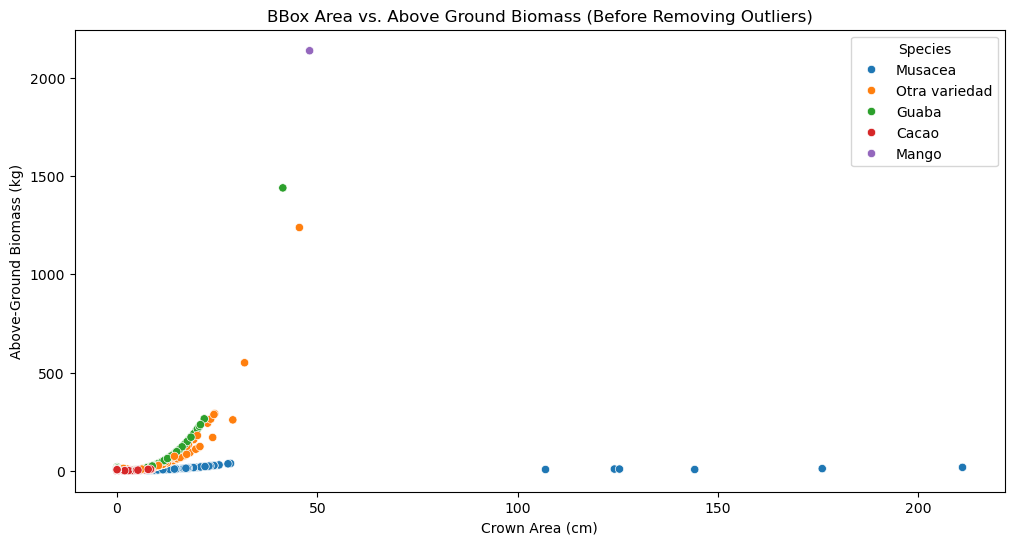

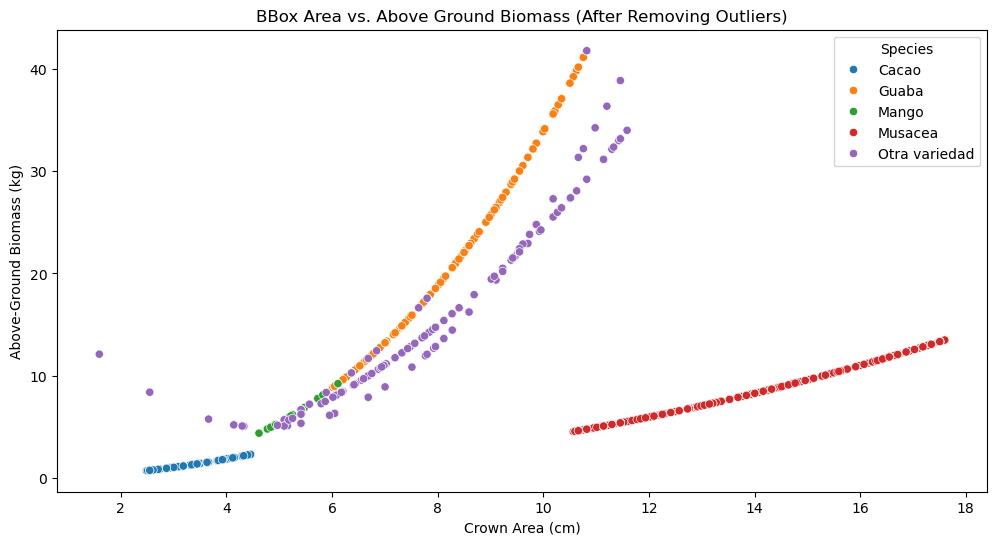

In [11]:
mu.visualize_allometric_relationship(df_relevant, 'BBox Area vs. Above Ground Biomass (Before Removing Outliers)')
mu.visualize_allometric_relationship(df_cleaned, 'BBox Area vs. Above Ground Biomass (After Removing Outliers)')

## Base model

Species: Cacao
Mean Squared Error: 1.330655365587692e-19
R^2 Score: 1.0
Intercept (a): 0.12079999985756128
Coefficient (b): 1.9800000009150522


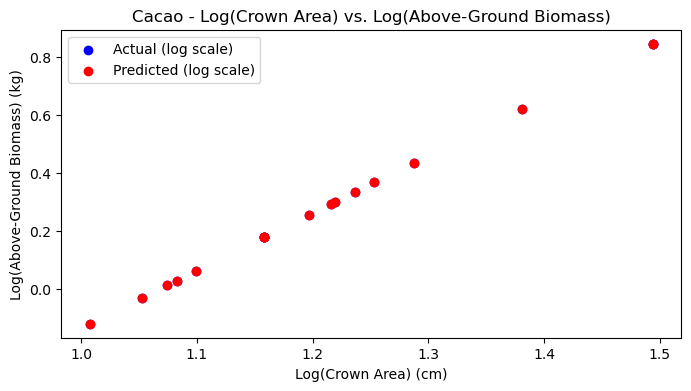

Species: Guaba
Mean Squared Error: 3.857086433633476e-20
R^2 Score: 1.0
Intercept (a): 0.07762471164686086
Coefficient (b): 2.640000000099071


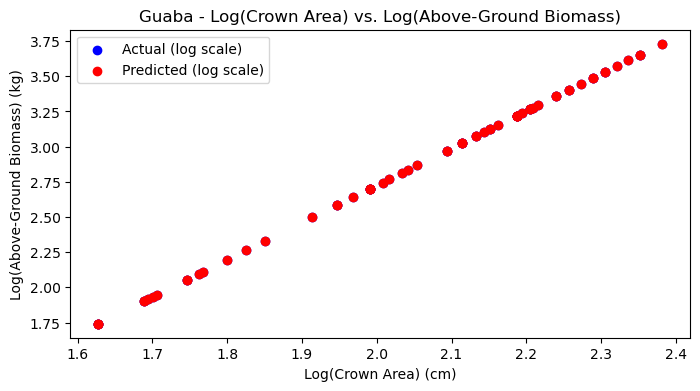

Species: Mango
Mean Squared Error: 2.3905621308634086e-20
R^2 Score: 1.0
Intercept (a): 0.07762471158288745
Coefficient (b): 2.6400000006127966


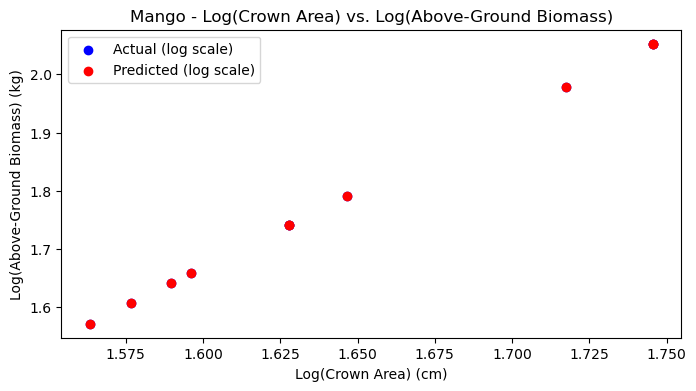

Species: Musacea
Mean Squared Error: 2.1335140268800727e-19
R^2 Score: 1.0
Intercept (a): 0.029999999996443746
Coefficient (b): 2.1300000000579034


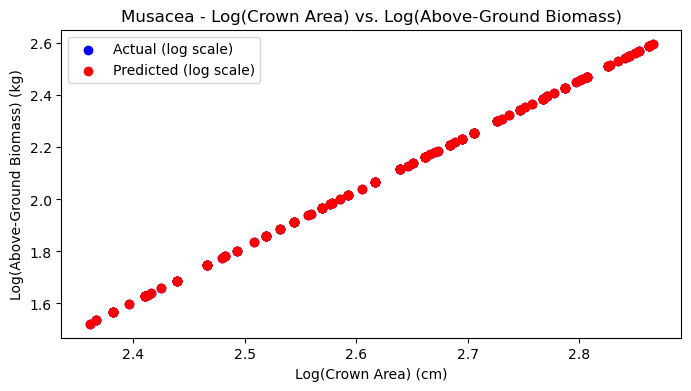

Species: Otra variedad
Mean Squared Error: 0.04603735866822456
R^2 Score: 0.8705606333162406
Intercept (a): 0.6015927203076032
Coefficient (b): 1.5392591217879739


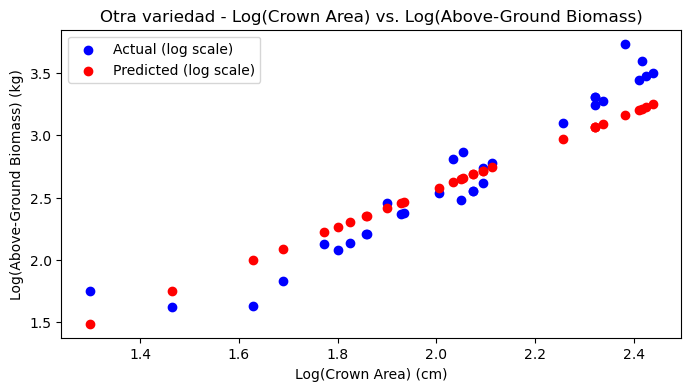

In [12]:
# List of unique species
species_list = df_cleaned['name'].unique()

# Fit and evaluate models for each species, and extract coefficients
models = {}
coefficients = {}
for species in species_list:
    model, intercept, coefficient = mu.fit_and_evaluate_log_log_model(df_cleaned, species)
    models[species] = model
    coefficients[species] = (intercept, coefficient)


### Cross-Val Scores

In [13]:
mu.calculate_cross_val_score(models, df_cleaned)

Species: Cacao
Cross-Validation R^2 Scores: [1. 1. 1. 1. 1.]
Mean R^2 Score: 1.0
Species: Guaba
Cross-Validation R^2 Scores: [1. 1. 1. 1. 1.]
Mean R^2 Score: 1.0
Species: Mango
Cross-Validation R^2 Scores: [1. 1. 1. 1. 1.]
Mean R^2 Score: 1.0
Species: Musacea
Cross-Validation R^2 Scores: [1. 1. 1. 1. 1.]
Mean R^2 Score: 1.0
Species: Otra variedad
Cross-Validation R^2 Scores: [ 0.82131435  0.86844403  0.85558296 -0.8526388   0.89855958]
Mean R^2 Score: 0.5182524240348861


array([ 0.82131435,  0.86844403,  0.85558296, -0.8526388 ,  0.89855958])

### Linear Model

Species: Cacao
Mean Squared Error: 0.0017016265322909827
R^2 Score: 0.9901543599657506
Intercept: -1.2969561621069616
Coefficient: 0.794143003996095


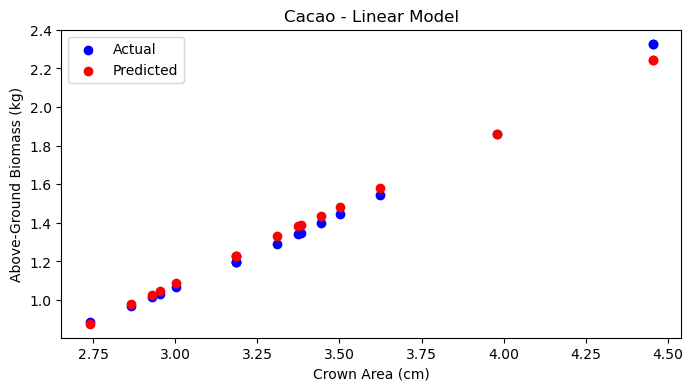

Species: Guaba
Mean Squared Error: 2.5350110517983717
R^2 Score: 0.9730938650219502
Intercept: -29.157857010554597
Coefficient: 6.201979201438939


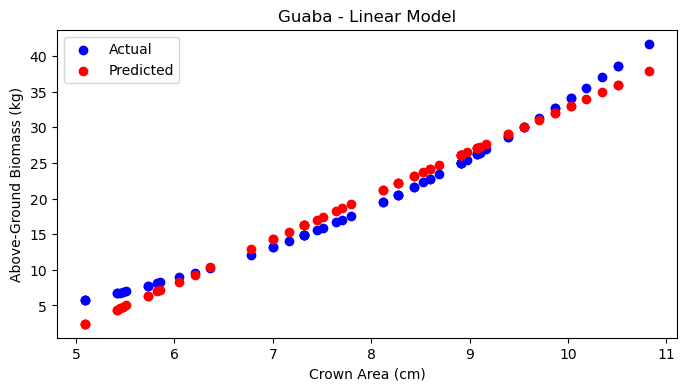

Species: Mango
Mean Squared Error: 0.0022003248307909005
R^2 Score: 0.998131693006888
Intercept: -10.496027512937053
Coefficient: 3.1930953542292424


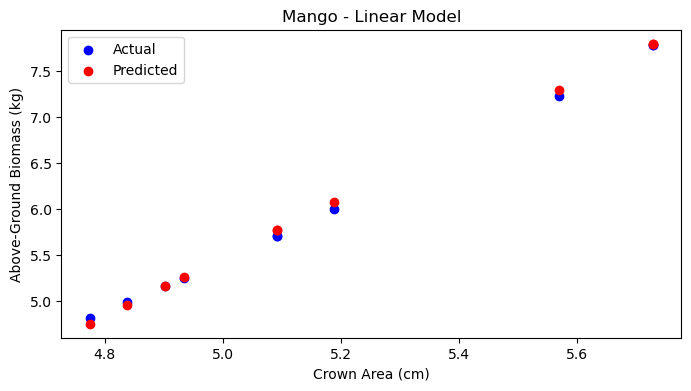

Species: Musacea
Mean Squared Error: 0.038641152288083604
R^2 Score: 0.9943001396874511
Intercept: -9.24263359107588
Coefficient: 1.266130176761301


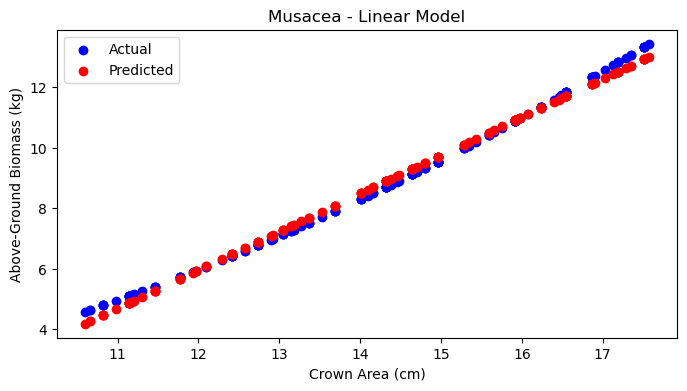

Species: Otra variedad
Mean Squared Error: 13.831445523899854
R^2 Score: 0.8639735948564715
Intercept: -14.611880293741203
Coefficient: 3.8569586124735276


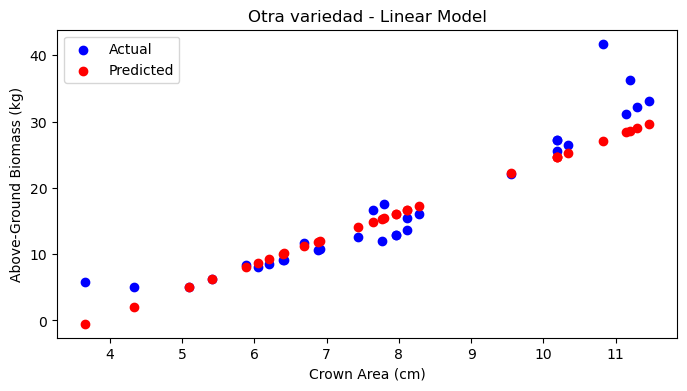

In [14]:
models = {}
coefficients = {}
for species in species_list:
    model, intercept, coefficient = mu.fit_and_evaluate_linear_model(df_cleaned, species)
    models[species] = model
    coefficients[species] = (intercept, coefficient)

### Exponential Model

Species: Cacao
Mean Squared Error: 0.003242316842653738
R^2 Score: 0.9812398996466201
Intercept (a): 0.17615750691495183
Coefficient (b): 0.5926693987537144


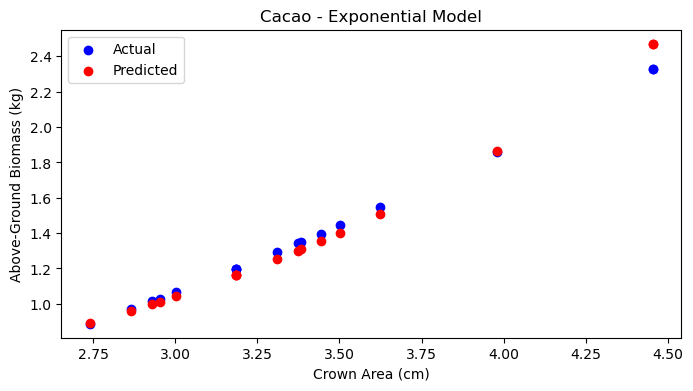

Species: Guaba
Mean Squared Error: 1.466294251190948
R^2 Score: 0.984437026019238
Intercept (a): 1.1404357604933764
Coefficient (b): 0.34317870341272316


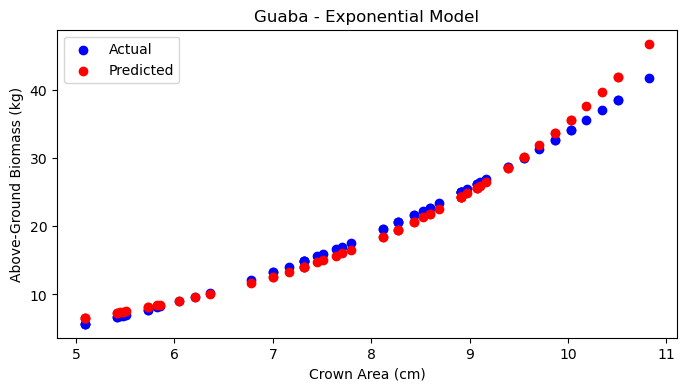

Species: Mango
Mean Squared Error: 0.000699340915352351
R^2 Score: 0.999406186075602
Intercept (a): 0.4505792504887369
Coefficient (b): 0.49731585363418274


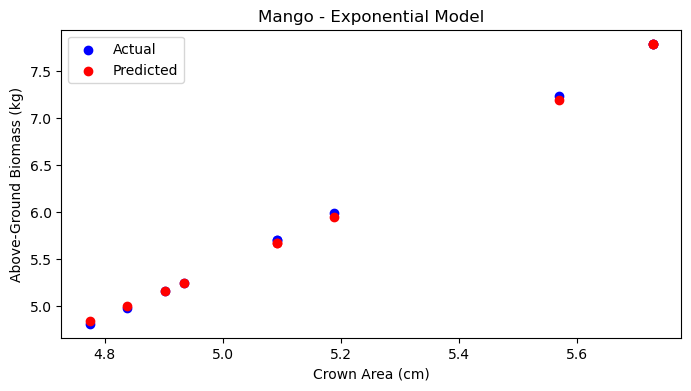

Species: Musacea
Mean Squared Error: 0.042400493751142805
R^2 Score: 0.9937456085739156
Intercept (a): 0.9447603470785553
Coefficient (b): 0.15358021788628137


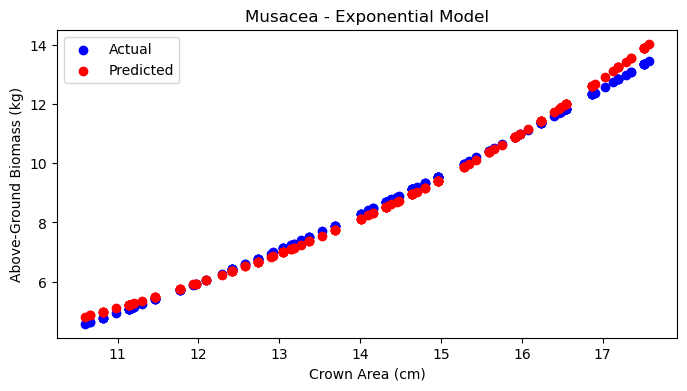

Species: Otra variedad
Mean Squared Error: 7.704660304301827
R^2 Score: 0.9242279310405206
Intercept (a): 1.804920462069923
Coefficient (b): 0.2571613799197714


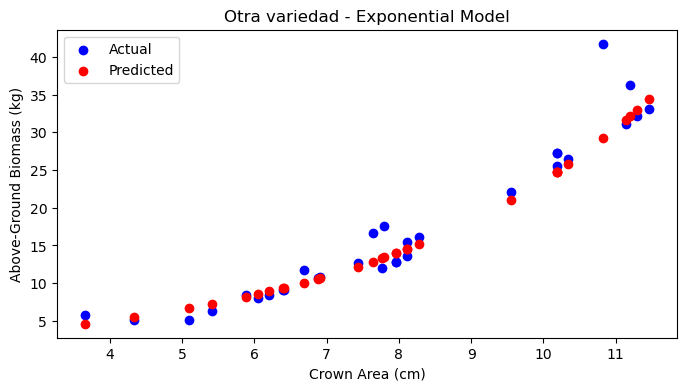

In [15]:
models = {}
coefficients = {}
for species in species_list:
    model, intercept, coefficient = mu.fit_and_evaluate_exponential_model(df_cleaned, species)
    models[species] = model
    coefficients[species] = (intercept, coefficient)

### Logarithmic Model

Species: Cacao
Mean Squared Error: 0.007116786182196728
R^2 Score: 0.9588221542030781
Intercept: -1.764451273818225
Coefficient: 2.6210810244496963


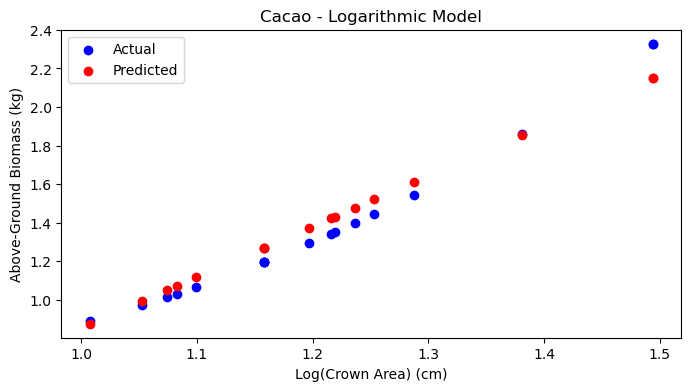

Species: Guaba
Mean Squared Error: 6.420350890094568
R^2 Score: 0.9318555918985925
Intercept: -74.83501736993402
Coefficient: 46.30404186618116


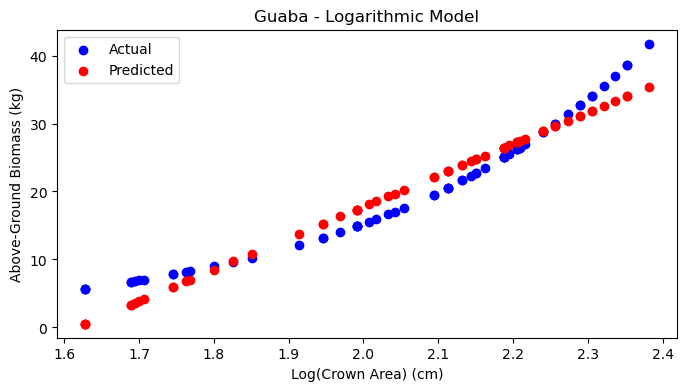

Species: Mango
Mean Squared Error: 0.005617523383084351
R^2 Score: 0.9952301323542241
Intercept: -21.68880555237419
Coefficient: 16.890831311568874


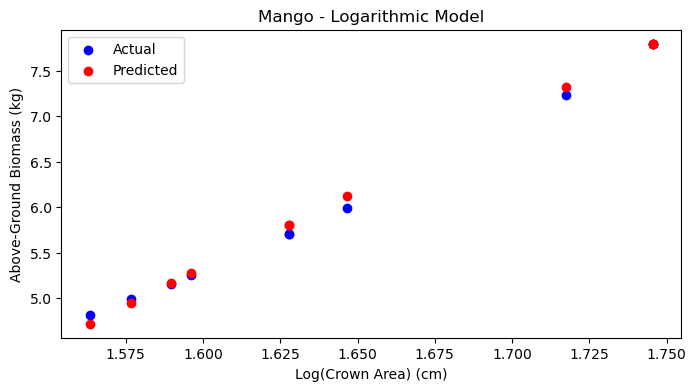

Species: Musacea
Mean Squared Error: 0.13868018294400514
R^2 Score: 0.9795436309712919
Intercept: -37.26301347809377
Coefficient: 17.40045613309253


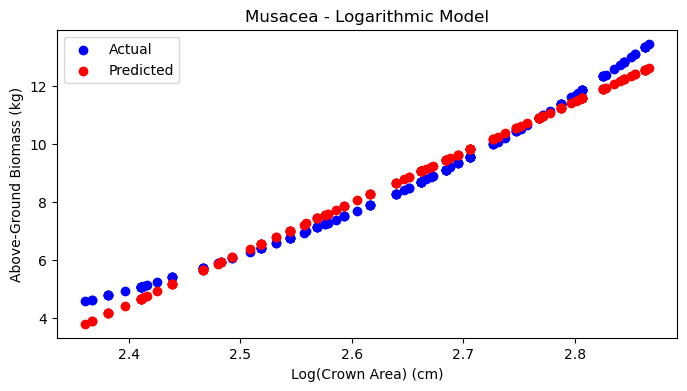

Species: Otra variedad
Mean Squared Error: 28.63701560426838
R^2 Score: 0.7183670875212014
Intercept: -29.96887719143301
Coefficient: 22.52917902413727


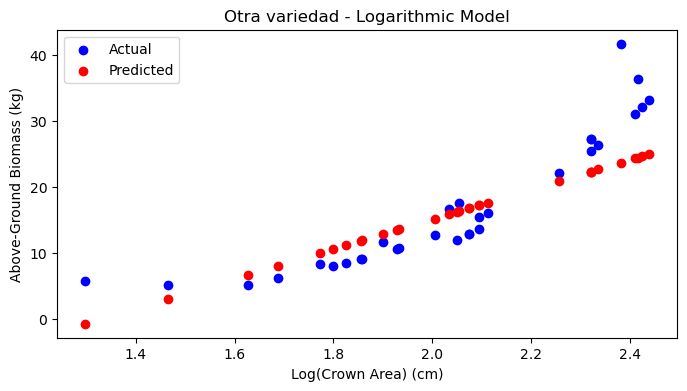

In [16]:
models = {}
coefficients = {}
for species in species_list:
    model, intercept, coefficient = mu.fit_and_evaluate_logarithmic_model(df_cleaned, species)
    models[species] = model
    coefficients[species] = (intercept, coefficient)

### Polynomial Model 

Species: Cacao
Mean Squared Error: 1.9472313784869945e-09
R^2 Score: 0.9999999887332861


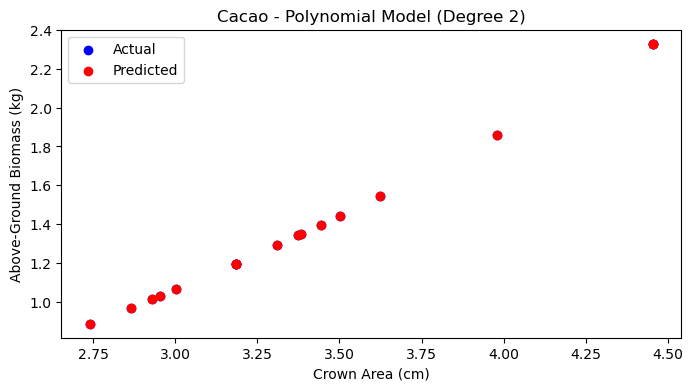

Species: Guaba
Mean Squared Error: 0.0040062419683556255
R^2 Score: 0.9999574784941948


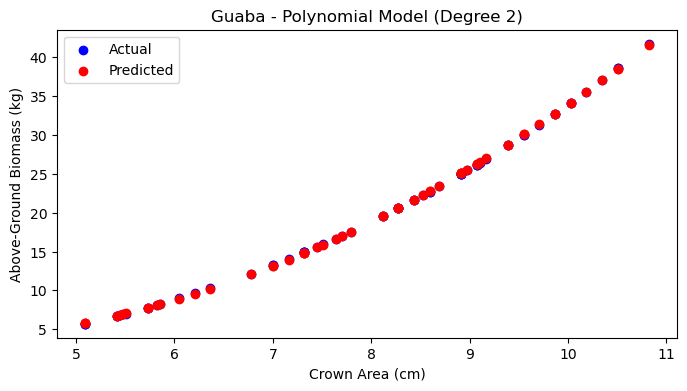

Species: Mango
Mean Squared Error: 1.4001198251877675e-06
R^2 Score: 0.9999988111511428


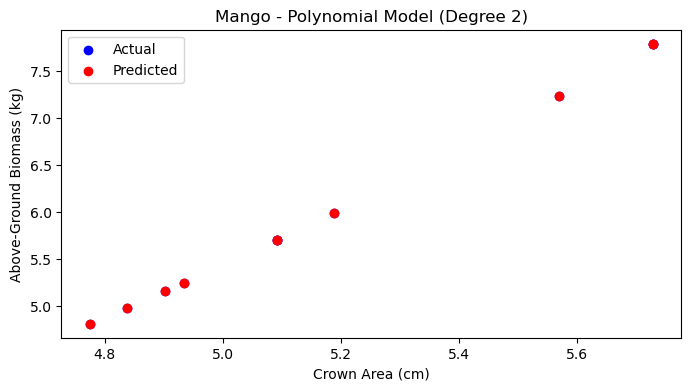

Species: Musacea
Mean Squared Error: 1.107289637295499e-06
R^2 Score: 0.9999998366664583


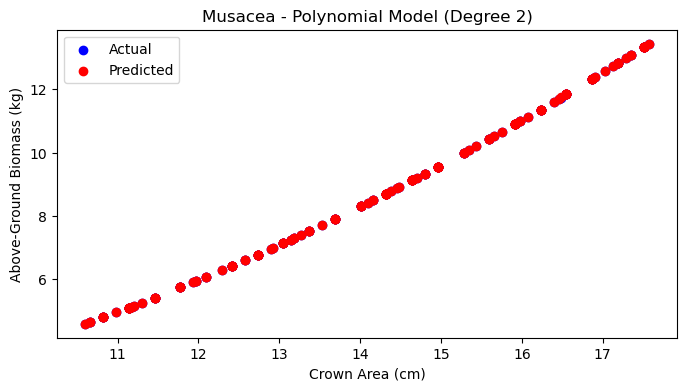

Species: Otra variedad
Mean Squared Error: 6.483926482903259
R^2 Score: 0.9362333308430967


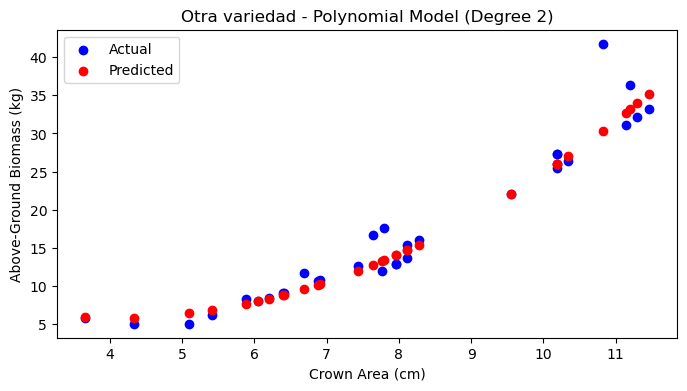

In [17]:
models = {}
coefficients = {}

for species in species_list:
    model, poly_coefficients = mu.fit_and_evaluate_polynomial_model(df_cleaned, species)
    models[species] = model
    coefficients[species] = poly_coefficients


In [18]:
mu.calculate_cross_val_score_poly(models, df_cleaned)

Species: Cacao
Cross-Validation R^2 Scores: [0.99099972 0.99168366 0.99531747 0.99395196 0.99040344]
Mean R^2 Score: 0.9924712501778089
Species: Guaba
Cross-Validation R^2 Scores: [0.96901283 0.96699297 0.97771368 0.95712088 0.97339463]
Mean R^2 Score: 0.9688469994630301
Species: Mango
Cross-Validation R^2 Scores: [0.99626253 0.99638292 0.99513625 0.99309281 0.99542887]
Mean R^2 Score: 0.9952606745102118
Species: Musacea
Cross-Validation R^2 Scores: [0.99422082 0.99404572 0.99451154 0.99442605 0.99402873]
Mean R^2 Score: 0.9942465709343947
Species: Otra variedad
Cross-Validation R^2 Scores: [0.89610388 0.87318229 0.92403669 0.65671802 0.97563911]
Mean R^2 Score: 0.8651359950206601


array([0.89610388, 0.87318229, 0.92403669, 0.65671802, 0.97563911])

### Generalized Additive Model 

Species: Cacao
Mean Squared Error: 3.119723223917731e-08
R^2 Score: 0.9999998522551782


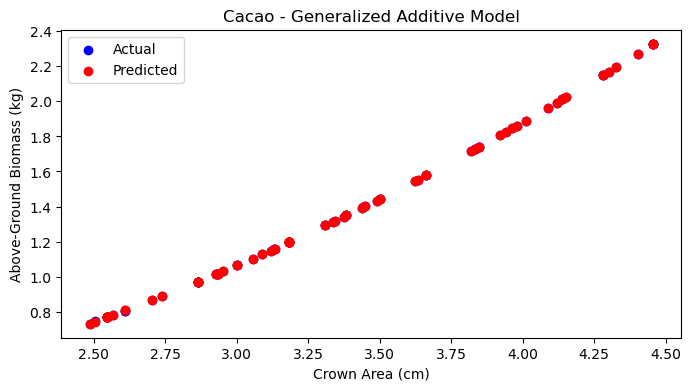

Species: Guaba
Mean Squared Error: 1.512873007462891e-05
R^2 Score: 0.9999998514589971


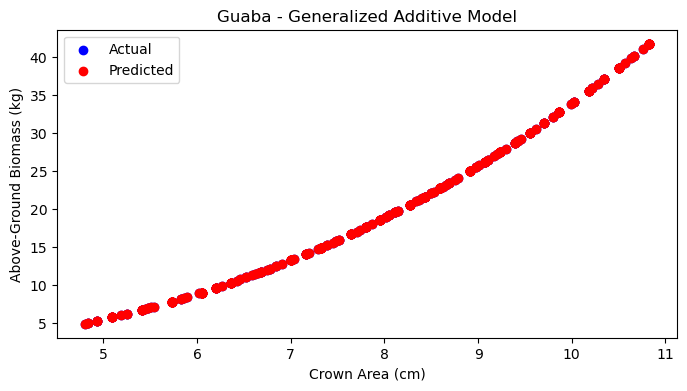

Species: Mango
Mean Squared Error: 2.620720044558649e-07
R^2 Score: 0.9999998429358629


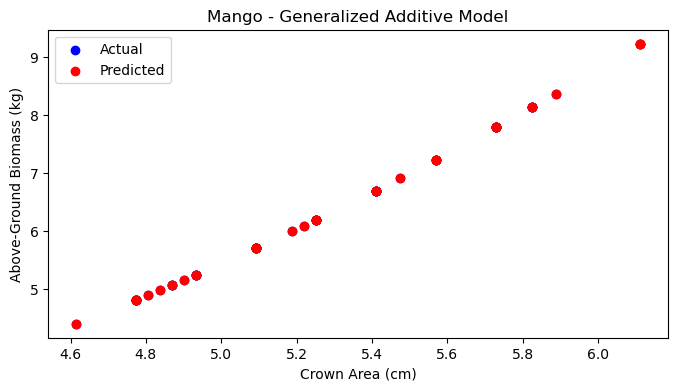

Species: Musacea
Mean Squared Error: 6.59354037998037e-08
R^2 Score: 0.9999999896312289


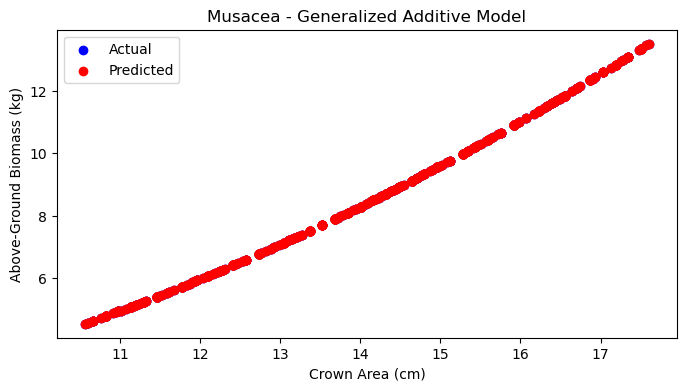

Species: Otra variedad
Mean Squared Error: 1.8290628368438726
R^2 Score: 0.9753863695849899


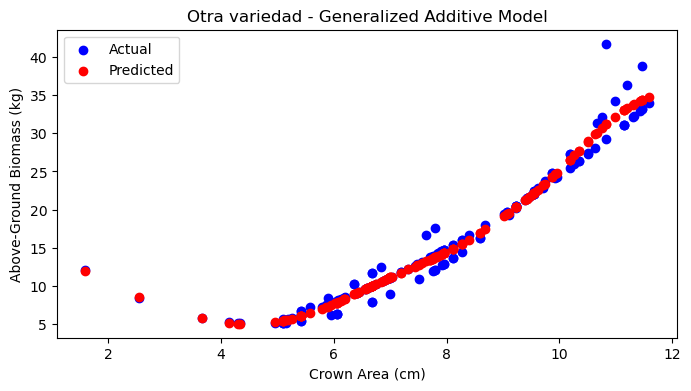

In [19]:
# Example usage
species_models = {}
for species in species_list:
    model = mu.fit_and_evaluate_gam_model(df_cleaned, species)
    species_models[species.lower()] = model  

In [20]:
mu.calculate_cross_val_score_gam(models, df_cleaned)

Species: Cacao
Cross-Validation R^2 Scores: [0.99099972 0.99168366 0.99531747 0.99395196 0.99040344]
Mean R^2 Score: 0.9924712501778089
Species: Guaba
Cross-Validation R^2 Scores: [0.96901283 0.96699297 0.97771368 0.95712088 0.97339463]
Mean R^2 Score: 0.9688469994630301
Species: Mango
Cross-Validation R^2 Scores: [0.99626253 0.99638292 0.99513625 0.99309281 0.99542887]
Mean R^2 Score: 0.9952606745102118
Species: Musacea
Cross-Validation R^2 Scores: [0.99422082 0.99404572 0.99451154 0.99442605 0.99402873]
Mean R^2 Score: 0.9942465709343947
Species: Otra variedad
Cross-Validation R^2 Scores: [0.89610388 0.87318229 0.92403669 0.65671802 0.97563911]
Mean R^2 Score: 0.8651359950206601


array([0.89610388, 0.87318229, 0.92403669, 0.65671802, 0.97563911])

In [22]:
#saving this model because it will be the one I use 
save_directory = 'models/allometric_models/'
for species, model in species_models.items():
    save_path = os.path.join(save_directory, f'{species}_gam_model.pkl')
    with open(save_path, 'wb') as f:
        pickle.dump(model, f)

    print(f"Saved {species} model to {save_path}")

Saved cacao model to models/allometric_models/cacao_gam_model.pkl
Saved guaba model to models/allometric_models/guaba_gam_model.pkl
Saved mango model to models/allometric_models/mango_gam_model.pkl
Saved musacea model to models/allometric_models/musacea_gam_model.pkl
Saved otra variedad model to models/allometric_models/otra variedad_gam_model.pkl


## Applying this to the whole spreadsheet

In [23]:
df_result = df_cleaned.copy()
df_result['AGB_predicted'] = df_cleaned.apply(
    lambda x: du.calculate_AGB(x['diameter'], x['name']),
    axis=1
)

df_result['AGB_difference'] = np.abs(df_result['AGB'] - df_result['AGB_predicted'])

# Flag significant differences (e.g., differences greater than 20% of the actual AGB)
df_result['AGB_difference_flag'] = df_result.apply(
    lambda x: 'Yes' if x['AGB_difference'] >= 0.2 * x['AGB'] else 'No', axis=1
)


In [24]:
df_result['AGB_difference_flag'].value_counts()

AGB_difference_flag
No     1370
Yes      10
Name: count, dtype: int64

In [25]:
#show 20 of the rows with the highest differences
df_result.sort_values(by='AGB_difference', ascending=False).head(20)

,name,diameter,AGB,AGB_predicted,AGB_difference,AGB_difference_flag
1256,Otra variedad,10.822511,41.747070,31.189177,10.557892,Yes
1338,Otra variedad,11.459129,38.829666,34.314899,4.514768,No
1254,Otra variedad,7.798574,17.576003,13.727312,3.848691,Yes
1372,Otra variedad,7.639419,16.644829,13.208835,3.435993,Yes
1300,Otra variedad,11.204482,36.328757,33.302416,3.026341,No
1227,Otra variedad,7.002801,8.919558,11.105567,2.186010,Yes
1298,Otra variedad,6.684492,7.907781,10.004238,2.096457,Yes
1229,Otra variedad,6.684492,7.907781,10.004238,2.096457,Yes
1258,Otra variedad,10.981665,34.219187,32.177471,2.041716,No
1283,Otra variedad,10.822511,29.195183,31.189177,1.993994,No


In [26]:
#show the 20 rows with the highest differences, excluding otra variedad name 
df_result[df_result['name'] != 'Otra variedad'].sort_values(by='AGB_difference', ascending=False).head(20)

,name,diameter,AGB,AGB_predicted,AGB_difference,AGB_difference_flag
389,Guaba,4.806468,4.898023,4.874532,0.023491,No
355,Guaba,4.838299,4.984123,4.966257,0.017866,No
300,Guaba,4.838299,4.984123,4.966257,0.017866,No
157,Guaba,10.822511,41.747070,41.734333,0.012736,No
270,Guaba,10.822511,41.747070,41.734333,0.012736,No
261,Guaba,10.822511,41.747070,41.734333,0.012736,No
332,Guaba,10.822511,41.747070,41.734333,0.012736,No
167,Guaba,10.822511,41.747070,41.734333,0.012736,No
375,Guaba,10.822511,41.747070,41.734333,0.012736,No
380,Guaba,10.822511,41.747070,41.734333,0.012736,No
